# Imports and Definitions

In [12]:
import sys
sys.path.append('../')

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from utils.data_utils import preprocess_and_normalize_energy_data, parse_codecarbon_output
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score
from utils.experiments_utils import split_data_set, fit_model, compute_log_transformed_features, apply_data_transforms, test_model
%load_ext autoreload
%autoreload 2
SEED = 1223

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
param_cols = ['batch_size','image_size','kernel_size','in_channels','stride','padding']
models = {}
estimates = {}

# MaxPooling2D Module
## Load Data

In [15]:
d1 = parse_codecarbon_output(
    '../data/maxpool2d/00_maxpool2d-raw.csv',
    False,
    ('../data/maxpool2d/00_maxpool2d-slurm-log.out','maxpool2d',False,3)
)
print("dataset shape:", d1.shape)

Dropped observations with the following indices: [60, 237, 238, 392, 617, 681, 763, 859, 957, 1021, 1113, 1153, 1287, 1305, 1433, 1440]
dataset shape: (1484, 38)


In [16]:
d2 = parse_codecarbon_output(
    '../data/maxpool2d/02_maxpool2d-raw.csv',
    False,
    ('../data/maxpool2d/02_maxpool2d-slurm-log.out','maxpool2d',True,3)
)
print("dataset shape:", d2.shape)

Dropped observations with the following indices: [45, 46, 47, 105, 106, 107, 213, 214, 215, 249, 250, 251, 372, 373, 374, 378, 379, 380, 531, 532, 533, 540, 541, 542, 801, 802, 803, 843, 844, 845, 1023, 1024, 1025, 1095, 1096, 1097, 1176, 1177, 1178, 1236, 1237, 1238, 1362, 1363, 1364]
dataset shape: (1455, 38)


In [17]:
data_unnormalized = pd.concat([d1,d2])
data = preprocess_and_normalize_energy_data(data_unnormalized, param_cols, aggregate=True)

Final shape of data set: (985, 27)


## Feature Set: Parameters

In [18]:
print(f"Used features: {param_cols}")
dfs = split_data_set(data, param_cols, SEED)
transformers_dict = {
    "x_preprocessors": [PolynomialFeatures(degree=2, interaction_only=True)],
    "y_preprocessor": MinMaxScaler()
}
dfs, _ = apply_data_transforms(dfs, transformers_dict)
model, *_ = fit_model(Lasso(max_iter=int(1e5)), dfs["x_train"], dfs["y_train"], dfs["x_val"], dfs["y_val"], plot_results=False)

Used features: ['batch_size', 'image_size', 'kernel_size', 'in_channels', 'stride', 'padding']
Average R2 Cross-Validation Score: 0.470 (± 0.102)
Average MSE Cross-Validation: -2.126e-03 (± 2.020e-03)
Validation R2 Score: 0.502
Validation MSE: 1.132e-03


Test R2 Score: 0.357
Test MSE: 7.609e-03


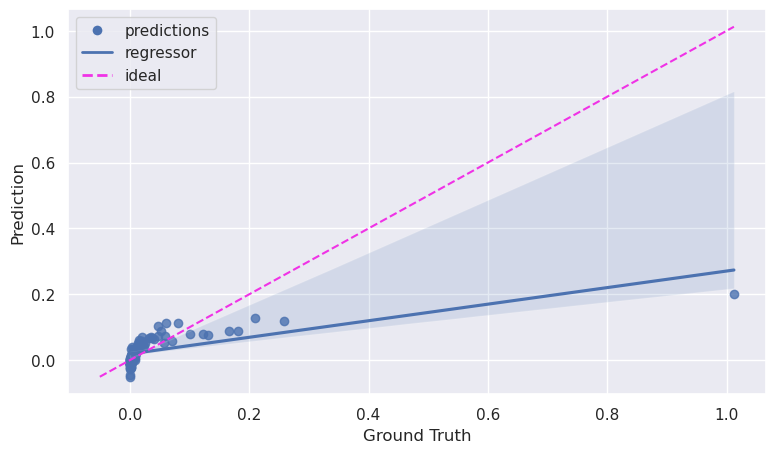

In [19]:
y_hat, *_ = test_model(model,dfs["x_test"],dfs["y_test"],plot_results=True)

In [20]:
# save model & estimates
models['param'] = model
estimates['param'] = y_hat

### Notes
- standard LinearRegression without polynomial features does not work at all
- degree 2 only one with a positive R2 cross-val score
- degree 3 & 4 achieve better scores, but deviations are extreme and unreliable
- Lasso more reliable with polynomials, the opposite is true if no polynomials

## Feature-Set: Module Parameters + Log-Parameters


In [21]:
data_linear_with_log, param_cols_with_log = compute_log_transformed_features(data, param_cols)
print(f"Used features: {param_cols_with_log}")
dfs = split_data_set(data_linear_with_log, param_cols_with_log, SEED)
transformers_dict = {
    "x_preprocessors": [PolynomialFeatures(degree=2, interaction_only=True)],
    "y_preprocessor": MinMaxScaler()
}
dfs, _ = apply_data_transforms(dfs, transformers_dict)
model, *_ = fit_model(Lasso(max_iter=int(1e5)), dfs["x_train"], dfs["y_train"], dfs["x_val"], dfs["y_val"], plot_results=False)

Used features: ['batch_size', 'image_size', 'kernel_size', 'in_channels', 'stride', 'padding', 'log_batch_size', 'log_image_size', 'log_kernel_size', 'log_in_channels', 'log_stride', 'log_padding']
Average R2 Cross-Validation Score: 0.470 (± 0.102)
Average MSE Cross-Validation: -2.126e-03 (± 2.020e-03)
Validation R2 Score: 0.502
Validation MSE: 1.132e-03


Test R2 Score: 0.357
Test MSE: 7.609e-03


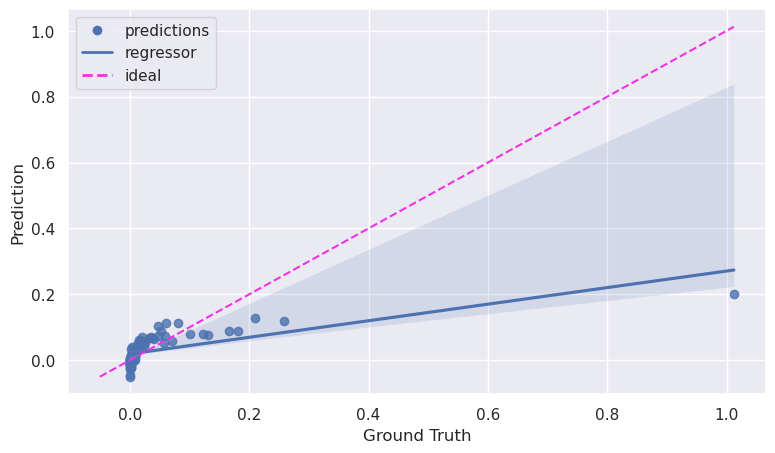

In [22]:
y_hat, *_ = test_model(model,dfs["x_test"],dfs["y_test"],plot_results=True)

In [23]:
# save model & estimates
models['param_log_param'] = model
estimates['param_log_param'] = y_hat

### Notes
- log-params offer no real improvements

## Feature-Set: MACs Only


In [24]:
dfs = split_data_set(data, ['macs'], SEED)
transformers_dict = {
    "x_preprocessors": None,
    "y_preprocessor": MinMaxScaler()
}
dfs, _ = apply_data_transforms(dfs, transformers_dict)
model, *_ = fit_model(LinearRegression(), dfs["x_train"], dfs["y_train"], dfs["x_val"], dfs["y_val"], plot_results=False)

Average R2 Cross-Validation Score: 0.973 (± 0.022)
Average MSE Cross-Validation: -6.760e-05 (± 3.994e-05)
Validation R2 Score: 0.951
Validation MSE: 1.106e-04


Test R2 Score: 0.986
Test MSE: 1.655e-04


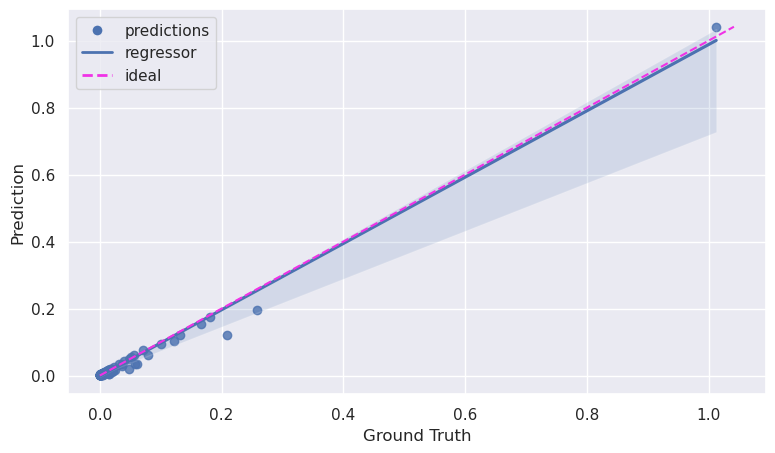

In [25]:
y_hat, *_ = test_model(model,dfs["x_test"],dfs["y_test"],plot_results=True)

In [26]:
# save model & estimates
models['macs'] = model
estimates['macs'] = y_hat

### Notes
- achieves incredible performance out of the box with very small deviations and seems to be very reliable

# Feature-Set: Module Parameters + MACs


In [27]:
print(f"Used features: {param_cols + ['macs']}")
dfs = split_data_set(data, param_cols + ['macs'], SEED)
transformers_dict = {
    "x_preprocessors": [PolynomialFeatures(degree=2, interaction_only=True),StandardScaler()],
    "y_preprocessor": MinMaxScaler()
}
dfs, _ = apply_data_transforms(dfs, transformers_dict)
model, *_ = fit_model(LinearRegression(), dfs["x_train"], dfs["y_train"], dfs["x_val"], dfs["y_val"], plot_results=False)

Used features: ['batch_size', 'image_size', 'kernel_size', 'in_channels', 'stride', 'padding', 'macs']
Average R2 Cross-Validation Score: 0.995 (± 0.003)
Average MSE Cross-Validation: -1.769e-05 (± 1.442e-05)
Validation R2 Score: 0.995
Validation MSE: 1.176e-05


Test R2 Score: 0.999
Test MSE: 8.951e-06


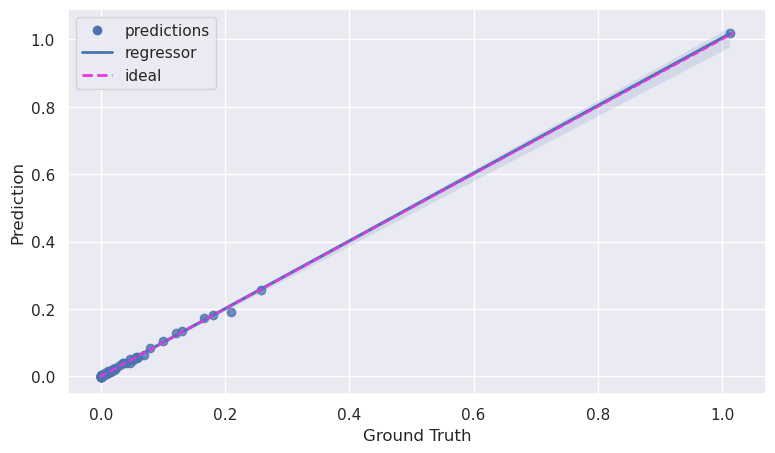

In [28]:
y_hat, *_ = test_model(model,dfs["x_test"],dfs["y_test"],plot_results=True)

In [29]:
# save model & estimates
models['param_macs'] = model
estimates['param_macs'] = y_hat

### Notes
- adding the parameters to the MACs only model seems to offer some improvements, if only small ones
- furthermore allowing for polynomial terms significantly reduces the MSE and improves the overall performance
- no benefit from going beyond degree 2
- StandardScaler seems to be helping quite a bit in reducing the error
- Lasso offers no added value

## Feature-Set: Module Parameters + Log-Parameters + MACs


In [30]:
data_linear_with_log, param_cols_with_log = compute_log_transformed_features(data, param_cols)
print(f"Used features: {param_cols_with_log + ['macs']}")
dfs = split_data_set(data_linear_with_log, param_cols_with_log + ['macs'], SEED)
transformers_dict = {
    "x_preprocessors": [PolynomialFeatures(degree=2, interaction_only=True),StandardScaler()],
    "y_preprocessor": MinMaxScaler()
}
dfs, _ = apply_data_transforms(dfs, transformers_dict)
model, *_ = fit_model(LinearRegression(), dfs["x_train"], dfs["y_train"], dfs["x_val"], dfs["y_val"], plot_results=False)

Used features: ['batch_size', 'image_size', 'kernel_size', 'in_channels', 'stride', 'padding', 'log_batch_size', 'log_image_size', 'log_kernel_size', 'log_in_channels', 'log_stride', 'log_padding', 'macs']
Average R2 Cross-Validation Score: 1.000 (± 0.000)
Average MSE Cross-Validation: -1.143e-06 (± 1.305e-06)
Validation R2 Score: 0.999
Validation MSE: 1.224e-06


Test R2 Score: 1.000
Test MSE: 1.200e-06


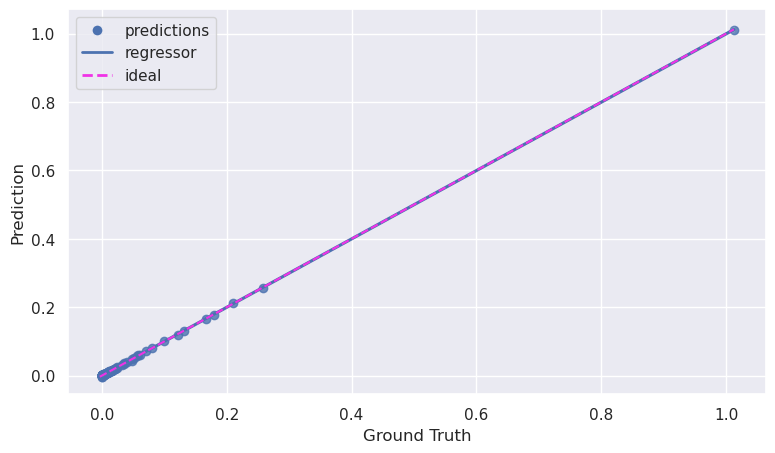

In [31]:
y_hat, *_ = test_model(model,dfs["x_test"],dfs["y_test"],plot_results=True)

In [32]:
# save model & estimates
models['param_log_param_macs'] = model
estimates['param_log_param_macs'] = y_hat

### Notes
- adding log parameters again seems to offer slight improvements even without polynomials
- adding degree 2 polynomials once again offers a substantial improvement and lower R2 scores
- more than degree 2 not decreases performance
- StandardScaler helps significantly

# Comparison of all models


param                               0.357
param_log_param                     0.357
macs                                0.986
param_macs                          0.999
param_log_param_macs                1.0


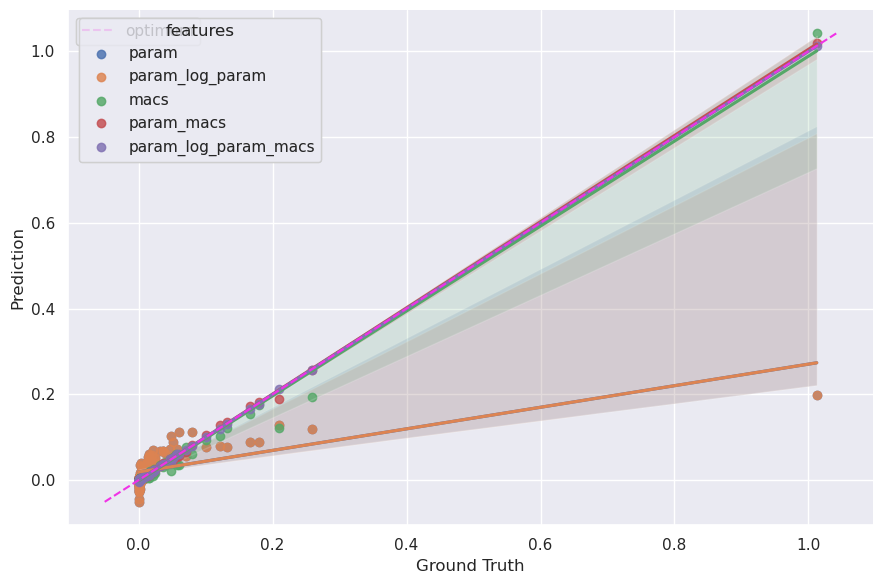

In [33]:
df_to_plot = pd.DataFrame(columns=["features","y_hat",'y'])
for model_name, model in models.items():
    new_df = pd.DataFrame(data={'features':[model_name]*len(dfs['y_test']),'y_hat':np.squeeze(estimates[model_name]),'y':np.squeeze(dfs['y_test'])})
    df_to_plot = pd.concat([df_to_plot, new_df], ignore_index=True)
    print(f"{'{:<35}'.format(model_name)} {round(r2_score(dfs['y_test'], estimates[model_name]), 3)}")
min_x = min(min(df_to_plot.y_hat),min(df_to_plot.y))
max_x = max(max(df_to_plot.y_hat),max(df_to_plot.y))
g = sns.lmplot(data=df_to_plot, x="y", y="y_hat", hue="features", ci=95, height=6, aspect=1.5, facet_kws={'legend_out':False}, markers='o')
plt.plot([min_x, max_x], [min_x, max_x],ls='--', marker='', label='optimum', color="#f032e6")
line = Line2D([0], [0], ls='--', label='optimum', color='#f032e6')
g.set(xlabel='Ground Truth', ylabel='Prediction')
sns.move_legend(g, "upper left", bbox_to_anchor=(.09, .97))
legend1 = g.legend
legend2 = plt.legend(handles = [plt.plot([],ls="--", color=line.get_color())[0]], labels=[line.get_label()], loc='best')
g.fig.add_artist(legend1)
g.fig.add_artist(legend2)